In [189]:
import pandas as pd

train_df = pd.read_csv("train.csv")
train_df.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


<Axes: >

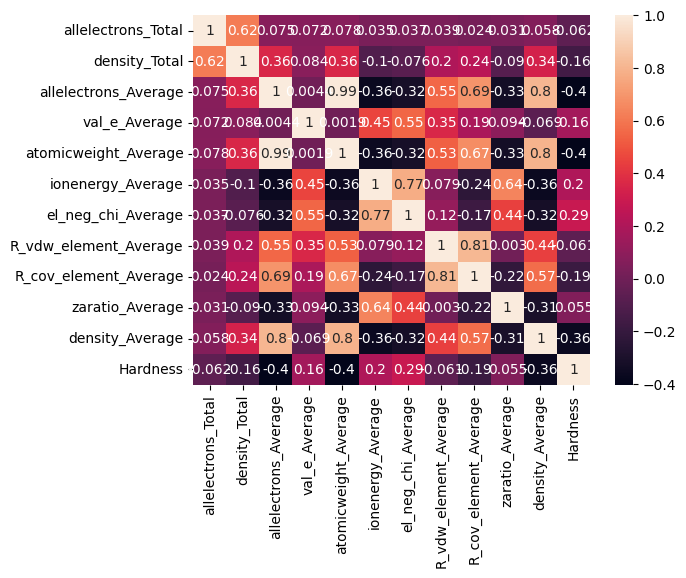

In [190]:
import seaborn as sns

corr_matrix = train_df.drop(columns=['id']).corr()
sns.heatmap(corr_matrix, annot=True)

In [191]:
X = train_df.drop(["id", "Hardness"], axis=1)
y = train_df[["Hardness"]].to_numpy().reshape((-1,))

In [192]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error, r2_score
import lightgbm as lgb
import warnings
import sys, os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

poly_ker = PolynomialFeatures(degree=2)
X_pol = poly_ker.fit_transform(X)
# X_test_pol = poly_ker.transform(X_test)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pol)
# X_test_scaled = scaler.transform(X_test_pol)

# Convert scaled data back to a DataFrame
X_scaled = pd.DataFrame(X_scaled)
    
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [193]:
# poly_ker = PolynomialFeatures(degree=2)
# X_train_pol = poly_ker.fit_transform(X_train)
# X_test_pol = poly_ker.transform(X_test)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_pol)
# X_test_scaled = scaler.transform(X_test_pol)

In [194]:
lgbm_params={'random_state': 1819, 'n_estimators': 309, 'reg_alpha': 0.009043959900513852, 'reg_lambda': 6.932606602460183, 'colsample_bytree': 0.6183243994985523, 'subsample': 0.6595851034943229, 'learning_rate': 0.016870023802940223, 'num_leaves': 50, 'min_child_samples': 27}

LGBModel = lgb.LGBMRegressor(**lgbm_params)
LGBModel.fit(X_scaled, y)
X_new = X_scaled.copy()
X_new['Hardness_pred'] = LGBModel.predict(X_scaled)


y_pred = LGBModel.predict(X_scaled)
median_absolute_error(y, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19183
[LightGBM] [Info] Number of data points in the train set: 10407, number of used features: 77
[LightGBM] [Info] Start training from score 4.647126


0.5497546626962491

In [195]:
from xgboost import XGBRegressor

model_params = {
            
        'colsample_bytree'            : .5,
        'subsample'                   : .5,
        'min_child_weight'            : 10,
        'learning_rate'               : .1,

        "n_estimators"                : 309,

        'random_state'                : 666 + 1,
        'tree_method'                 : "hist",
        'objective'                   : 'reg:linear',
        'eval_metric'                 : "mae",
        'disable_default_eval_metric' : True,
    }

xgmodel = XGBRegressor(**model_params)
xgmodel.fit(X_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None,
             disable_default_eval_metric=True, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=309, n_jobs=None,
             num_parallel_tree=None, ...)

In [196]:
y_pred = xgmodel.predict(X_scaled)

median_absolute_error(y, y_pred)

0.3788504123687746

In [197]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

In [198]:
from tensorflow.keras.callbacks import Callback

# Define a custom callback
class PrintEpochLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 == 0:
            print(f"Epoch {epoch} - Loss: {logs['loss']}")

In [199]:
def loss_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)
def metric_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp.stats.percentile(tf.abs(y_true - y_pred), q=0)

In [200]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150, verbose=2, mode='min', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN(),
    PrintEpochLoss()
] 

In [201]:
# Define the neural network model
nn_model = Sequential([
    InputLayer(input_shape=(X_new.shape[1],)),
    BatchNormalization(epsilon=0.00001),
    Dense(64, activation='gelu'),
    BatchNormalization(epsilon=0.00001),
    Dense(32, activation='gelu'),
    BatchNormalization(epsilon=0.00001),
    Dense(64, activation='gelu'),
    Dense(1)  # Single output node for regression
])

# Compile the model with Mean Absolute Error (MAE) as the metric
nn_model.compile(optimizer=Adam(0.013, beta_1=0.5), loss=loss_fn, metrics=metric_fn)

In [202]:
print_epoch_loss = PrintEpochLoss()

# Train the model on the training data
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Train the model on the training data with the defined callback
history = nn_model.fit(
    X_train_val, y_train_val, 
    epochs=500,
    batch_size=32,
    class_weight=LGBModel.class_weight,
    validation_data=(X_test_val, y_test_val), 
    callbacks=callbacks_list,
    verbose=0  # Set verbose to 0 to avoid redundant output
)

Epoch 0 - Loss: 1.623460054397583


Epoch 50 - Loss: 0.4538729786872864
Epoch 100 - Loss: 0.4482898712158203
Epoch 150 - Loss: 0.43780484795570374
Epoch 200 - Loss: 0.43143999576568604
Restoring model weights from the end of the best epoch: 61.
Epoch 211: early stopping


In [203]:
# Evaluate the model on the test data
mae = nn_model.evaluate(X_test_val, y_test_val, verbose=0)
print(f"MAE on test data: {mae}")

# Predictions on test data
y_pred = nn_model.predict(X_test_val)

# Calculate Median Absolute Error
mae_score = median_absolute_error(y_test_val, y_pred)
print(f"Mean Absolute Error: {mae_score}")

MAE on test data: [0.4233124852180481, 67770.234375]
66/66 [==============================] - 0s 998us/step
Mean Absolute Error: 0.3335123062133789


In [204]:
test_df = pd.read_csv("test.csv")

In [205]:
X_test = test_df.drop(["id"], axis=1)
X_test = poly_ker.transform(X_test)
X_test = scaler.transform(X_test)

# Convert scaled data back to a DataFrame
X_test = pd.DataFrame(X_test)

In [206]:
X_test_new = X_test.copy()
X_test_new['Hardness_pred'] = LGBModel.predict(X_test)

In [207]:
y_test = nn_model.predict(X_test_new)

217/217 [==============================] - 0s 1ms/step


In [208]:
# Create csv of y_test with columns "id" and "Hardness"
y_test_df = pd.DataFrame({'id': test_df['id'], 'Hardness': y_test.reshape((-1,))})
y_test_df.to_csv('predictions.csv', index=False)